In [2]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from sys import getsizeof

## Helper Function

In [3]:
def get_file_size(file_path):
  size = os.path.getsize(file_path)
  return size

In [4]:
def convert_bytes(size, unit=None):
  if unit == "KB":
    return print('File size: ' +str(round(size/1024, 3)) +' Kilobytes')
  elif unit == "MB":
    return print('File size: ' +str(round(size/(1024*1024), 3)) +' Megabytes')
  else:
    return print('File size: ' +str(size) +' bytes')


## Dataset

In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## EDA

In [7]:
train_images.shape

(60000, 28, 28)

In [8]:
len(train_labels)

60000

In [9]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [10]:
test_images.shape

(10000, 28, 28)

In [11]:
len(test_labels)

10000

## Preprocessing

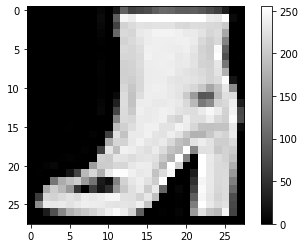

In [12]:
plt.figure()
plt.imshow(train_images[88], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [13]:
train_images = train_images / 255.0
test_images = test_images / 255.0

## Modelling

In [14]:
model = keras.Sequential([
                          Flatten(input_shape=(28,28)),
                          Dense(128, activation='relu'),
                          Dense(10)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4950 - accuracy: 0.8236
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3738 - accuracy: 0.8658
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3365 - accuracy: 0.8768
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3134 - accuracy: 0.8840
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2956 - accuracy: 0.8913
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2819 - accuracy: 0.8962
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2686 - accuracy: 0.9011
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2571 - accuracy: 0.9040
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2468 - accuracy: 0.9082
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.237

In [18]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"

In [19]:
model.save(KERAS_MODEL_NAME)

In [20]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.191 Megabytes


In [21]:
keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [22]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest Accuracy is {}%'.format(round(100*test_acc, 2)))

313/313 - 1s - loss: 0.3557 - accuracy: 0.8776 - 623ms/epoch - 2ms/step

Test Accuracy is 87.76%


## TF Lite Model

In [23]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

In [24]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmphu5jbbp9/assets


In [25]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

408628

In [26]:
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 399.051 Kilobytes


In [28]:
tflite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

## Check Input Tensor Shape

In [29]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


## Resize Tensor Shape

In [31]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [32]:
test_images.dtype

dtype('float64')

In [33]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)

In [34]:
test_imgs_numpy.dtype

dtype('float32')

In [35]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [36]:
acc = accuracy_score(prediction_classes, test_labels)

In [37]:
print('Test accuracy TFLITE model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE model is 87.76%


In [38]:
tflite_file_size/keras_model_size

0.32729200840680744

## TF Lite Model Float 16


In [39]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"

In [40]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmph3guakwe/assets


INFO:tensorflow:Assets written to: /tmp/tmph3guakwe/assets


In [41]:
tflite_model_name = TF_LITE_MODEL_FLOAT_16_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

205696

In [42]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 200.875 Kilobytes


In [43]:
tflite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [44]:
tflite_float_16_file_size/keras_model_size

0.1647529218782038

In [45]:
tflite_float_16_file_size/tflite_file_size

0.5033820491987823

 ## TF Lite Size Quantized


In [46]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = "tf_lite_quant_model.tflite"

In [47]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpba6sznm0/assets


INFO:tensorflow:Assets written to: /tmp/tmpba6sznm0/assets


In [48]:
tflite_model_name = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

103936

In [49]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")


File size: 101.5 Kilobytes


In [50]:
tflite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)


In [51]:
tflite_float_quant_file_size/keras_model_size


0.0832478982981341

In [52]:
tflite_float_quant_file_size/ tflite_float_16_file_size


0.5052893590541382

## Accuracy of the Quantized Model

In [54]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


In [55]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Type: <class 'numpy.float32'>


In [56]:
test_images.dtype


dtype('float64')

In [57]:
test_imgs_numpy = np.array(test_images, dtype=np.float32)


In [58]:
interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (10000, 10)


In [59]:
acc = accuracy_score(prediction_classes, test_labels)

In [60]:
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 87.55%
